I0000 00:00:1715524578.505789   93469 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


(110, 115)


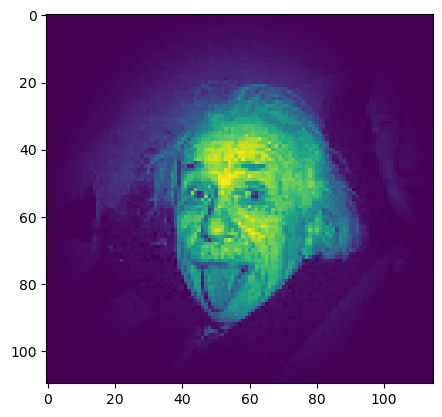

In [1]:
import jax
from jax import grad, jit, vmap, random
from jax.numpy.fft import fft, ifft
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

def add_noise(x, key):
    key, subkey = jax.random.split(key)
    s1, s2 = random.randint(subkey, (2,), 0, L)
    x = jnp.roll(jnp.roll(x, s1, axis=0), s2, axis=1)
    noise = pure_noise(sigma, key)
    return x + noise, noise, s1, s2

def pure_noise(sigma ,key):
    key, subkey = jax.random.split(key)
    noise = random.normal(subkey, (L, L)) * sigma
    return noise

def fft_2d(x):
    return fft(fft(x, axis=0), axis=1)

def fft_2d_center(x):
    (L1, L2) = x.shape
    x = fft_2d(x)
    x = jnp.roll(x, (L1//2, L2//2), axis=(0, 1))
    return x

def ifft_2d(x):
    return ifft(ifft(x, axis=0), axis=1)

def align(x, y):
    conv = ifft_2d(fft_2d(x) * jnp.conj(fft_2d(y))).real
    imax = jnp.argmax(conv)
    s1, s2 = jnp.unravel_index(imax, conv.shape)
    return jnp.roll(y, (s1, s2), axis=(0, 1))

def align_average(x, y):
    align_y = jit(vmap(lambda y: align(x, y)))
    return jnp.mean(align_y(y), axis=0)


s = 4
pic = mpimg.imread('/home/emastr/github/multireference-alignment/figures/einstein_tongue_2.jpg')[:, :, 0]
pic = pic[:-1:s, :-1:s]
(L1, L2) = pic.shape
t1 = jnp.linspace(0, 1, L1, endpoint=False)
t2 = jnp.linspace(0, 1, L2, endpoint=False)
T1, T2 = jnp.meshgrid(t1, t2)
vingette = 1/(1 + jnp.exp(-100 * (0.13**2 - (0.4*(T1 - 0.5) ** 2 + (T2 - 0.52) ** 2))))
pic = pic * vingette.T
pic = pic[20:130, 60:175]
#pic = pic[10:65, 35:85]
plt.imshow(pic)

print(pic.shape)


In [2]:

#y = jnp.roll(x, (3, 3), axis=(0, 1))
#y, s1, s2 = align(x, y)
#print(s1, s2)

#L = 5

sigma = 1000
#x = jnp.sin(-2*jnp.pi*jnp.sin(2 * jnp.pi * T1) * jnp.sin(2 * jnp.pi * T2))
#x = jnp.zeros((L, L))
#x = x.at[0,0].set(1.)
#x = jnp.where(T1 > 0.5, 1, 0) * jnp.where(T2 > 0.5, 1, 0)


N = 1000
x = jnp.array(pic)

(L1, L2) = pic.shape
t1 = jnp.linspace(0, 1, L1+1)[:-1]
t2 = jnp.linspace(0, 1, L2+1)[:-1]
T1, T2 = jnp.meshgrid(t1, t2)

y = random.normal(subkey, (N, L1, L2))
y = align_average(x, y)
xfft = fft_2d(x)

alignment = []
N_list = [8, 16, 32, 64, 128, 256, 512]#, 2048]#, 2*2048, 4*2048]
for N in N_list:
    key, subkey = jax.random.split(key)
    y = random.normal(subkey, (N, L1, L2))
    y = align_average(x, y)
    yfft = fft_2d(y)
    cosine = jnp.mean(jnp.abs(((xfft * jnp.conj(yfft)).real )/ (jnp.abs(xfft) * jnp.abs(yfft))), axis=(0, 1))
    alignment.append(cosine)

# Split into subtasks
N = 512
Nbatch = 512
for i in range(7):
    for j in range(2**i):
        key, subkey = jax.random.split(key)
        noise = random.normal(subkey, (Nbatch, L1, L2))
        y = (y * N +  align_average(x, noise) * Nbatch) / (N + Nbatch)
        N = N + Nbatch
    yfft = fft_2d(y)
    cosine = jnp.mean(jnp.abs(((xfft * jnp.conj(yfft)).real )/ (jnp.abs(xfft) * jnp.abs(yfft))), axis=(0, 1))
    alignment.append(cosine)
    N_list.append(N)
    


(110, 115) (110, 115)


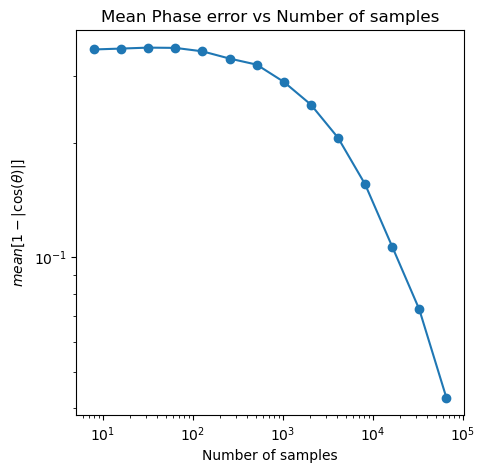

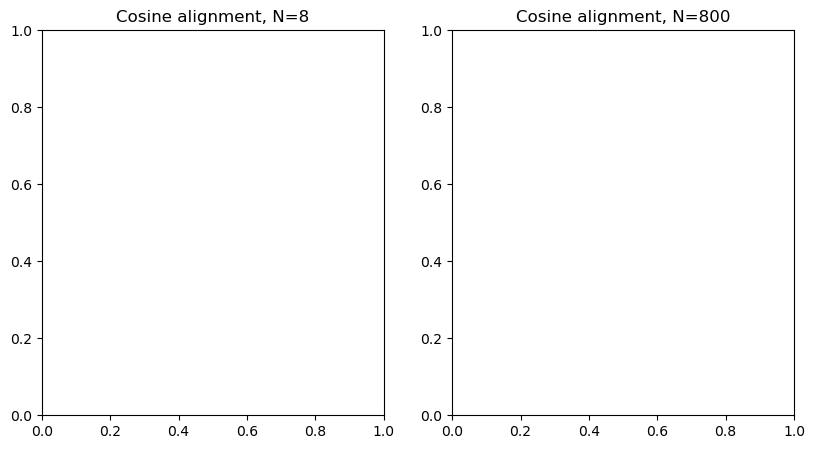

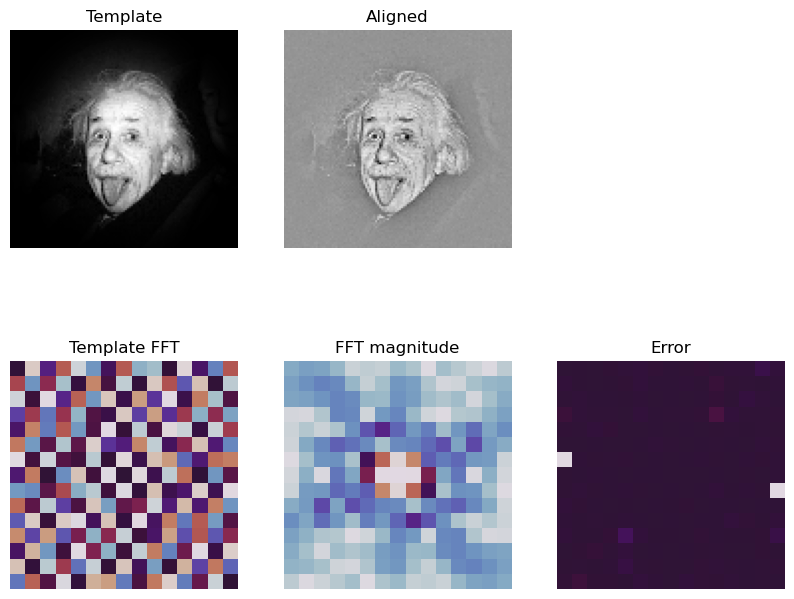

In [3]:
s2 = 8
xfft = fft_2d_center(x)#[::s2, ::s2])
yfft = fft_2d_center(y)#[::s2, ::s2])

xfft_n = xfft / jnp.abs(xfft)
yfft_n = yfft / jnp.abs(yfft)


Kmid1 = L1//2
Kmid2 = L2//2
L = 7
xfft_n = xfft_n[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1]
yfft_n = yfft_n[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1]
print(xfft.shape, yfft.shape)




plt.figure(figsize=(5, 5))
plt.plot(N_list, jnp.abs(1 - jnp.array(alignment)), 'o-')
plt.title("Mean Phase error vs Number of samples")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of samples")
plt.ylabel("$mean[1 - |\\cos(\\theta)|]$")

plt.figure(figsize=(15, 5))
for i, N in enumerate([8, 800]):#1000, 8000]):
    plt.subplot(1,3,i+1)
    y_ = random.normal(subkey, (N, L1, L2))
    y_ = align_average(x, y_)
    yfft_ = fft_2d(y_[::s2, ::s2])
    yfft_n_ = yfft_ / jnp.abs(yfft_)
    
    plt.title(f"Cosine alignment, N={N}")
    #plt.imshow((xfft_n * yfft_n_.conj()).real, vmin=-1, vmax=1, cmap="Greys_r")


cmap = "twilight"
plt.figure(figsize=(10, 8))
plt.subplot(231)
plt.axis("off")
plt.title("Template")
plt.imshow(x, cmap="Greys_r")


plt.subplot(232)
plt.axis("off")
plt.title("Aligned")
plt.imshow(y, cmap="Greys_r")

plt.subplot(232)
#plt.axis("off")
#plt.title("Aligned")
#plt.imshow(x/jnp.abs(x)-y, cmap="Greys_r")

plt.subplot(234)
plt.axis("off")
plt.title("Template FFT")
l = 2
#plt.imshow(jnp.log(jnp.abs(xfft)), cmap="Greys_r")
#plt.imshow(jnp.angle(xfft_n)%(l*jnp.pi), cmap=cmap, vmin=0, vmax=l*jnp.pi)
plt.imshow(jnp.angle(xfft_n), cmap=cmap, vmin=-jnp.pi, vmax=jnp.pi)
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), xfft_n.real, xfft_n.imag, color="white", scale=30)


plt.subplot(235)
plt.axis("off")
plt.title("FFT magnitude")
#plt.imshow(jnp.log(jnp.abs(yfft)), cmap="Greys_r")
#plt.imshow(jnp.angle(yfft_n)%(l*jnp.pi), cmap=cmap, vmin=0, vmax=l*jnp.pi)
#plt.imshow(jnp.angle(yfft_n), cmap=cmap, vmin=-jnp.pi, vmax=jnp.pi)
plt.imshow(jnp.abs(yfft[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1]), cmap=cmap)
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), yfft_n.real, yfft_n.imag, color="white", scale=30)


plt.subplot(236)
plt.axis("off")
plt.title("Error")
#plt.imshow(jnp.log(jnp.abs(yfft)), cmap="Greys_r")
#plt.imshow(jnp.angle(yfft_n)%(l*jnp.pi), cmap=cmap, vmin=0, vmax=l*jnp.pi)
plt.imshow(jnp.angle(yfft_n)-jnp.angle(xfft_n), cmap=cmap, vmin=-jnp.pi, vmax=jnp.pi)
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), yfft_n.real, yfft_n.imag, color="white", scale=30)



(110, 115) (110, 115)


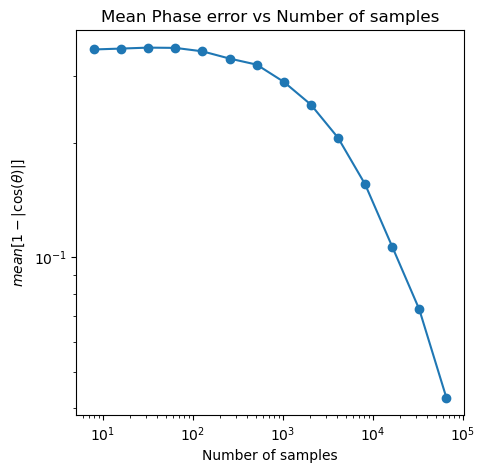

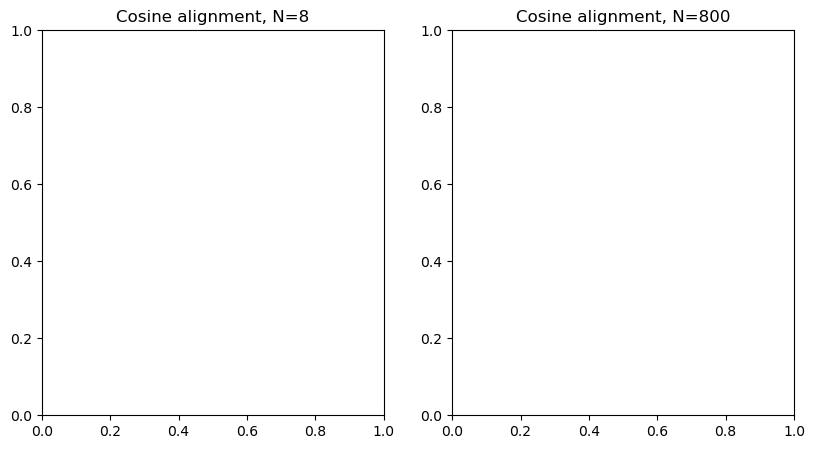

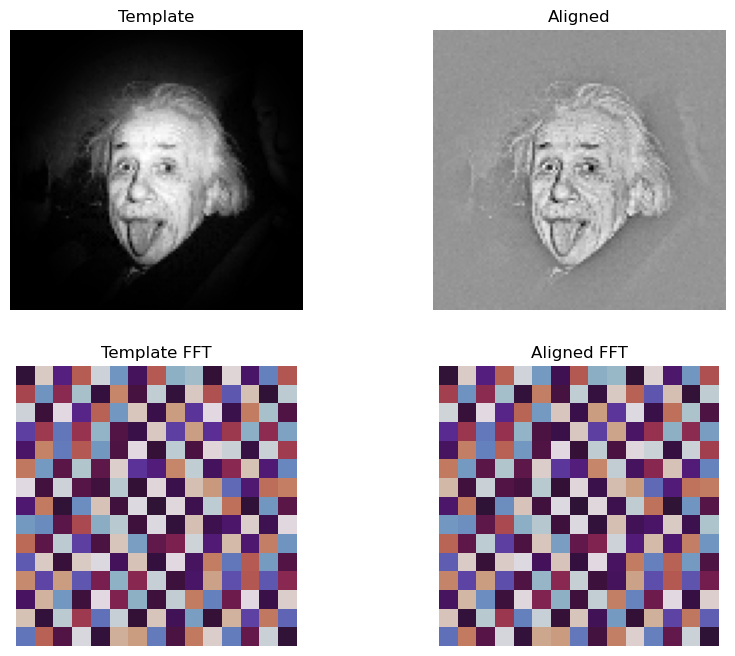

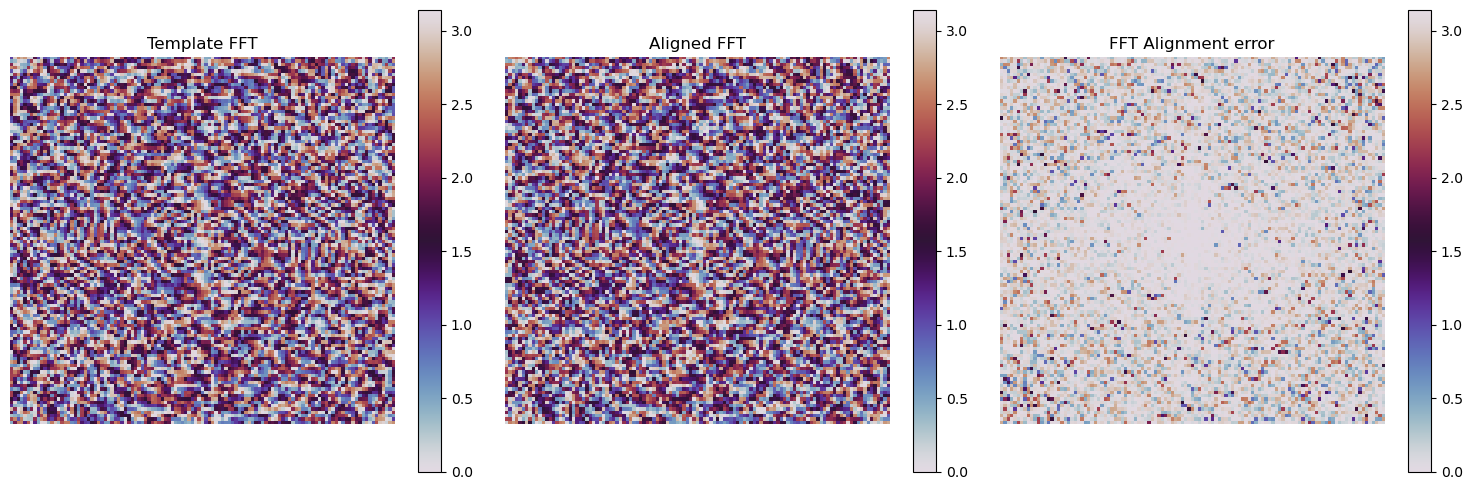

In [4]:
s2 = 8
xfft = fft_2d_center(x)#[::s2, ::s2])
yfft = fft_2d_center(y)#[::s2, ::s2])

xfft_n = xfft / jnp.abs(xfft)
yfft_n = yfft / jnp.abs(yfft)


Kmid1 = L1//2
Kmid2 = L2//2
L = 7
xfft_n = xfft_n[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1]
yfft_n = yfft_n[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1]
print(xfft.shape, yfft.shape)




plt.figure(figsize=(5, 5))
plt.plot(N_list, jnp.abs(1 - jnp.array(alignment)), 'o-')
plt.title("Mean Phase error vs Number of samples")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of samples")
plt.ylabel("$mean[1 - |\\cos(\\theta)|]$")

plt.figure(figsize=(15, 5))
for i, N in enumerate([8, 800]):#1000, 8000]):
    plt.subplot(1,3,i+1)
    y_ = random.normal(subkey, (N, L1, L2))
    y_ = align_average(x, y_)
    yfft_ = fft_2d(y_[::s2, ::s2])
    yfft_n_ = yfft_ / jnp.abs(yfft_)
    
    plt.title(f"Cosine alignment, N={N}")
    #plt.imshow((xfft_n * yfft_n_.conj()).real, vmin=-1, vmax=1, cmap="Greys_r")


cmap = "twilight"
plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.axis("off")
plt.title("Template")
plt.imshow(x, cmap="Greys_r")


plt.subplot(222)
plt.axis("off")
plt.title("Aligned")
plt.imshow(y, cmap="Greys_r")

plt.subplot(223)
plt.axis("off")
plt.title("Template FFT")
l = 2
#plt.imshow(jnp.log(jnp.abs(xfft)), cmap="Greys_r")
#plt.imshow(jnp.angle(xfft_n)%(l*jnp.pi), cmap=cmap, vmin=0, vmax=l*jnp.pi)
plt.imshow(jnp.angle(xfft_n), cmap=cmap, vmin=-jnp.pi, vmax=jnp.pi)
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), xfft_n.real, xfft_n.imag, color="white", scale=30)


plt.subplot(224)
plt.axis("off")
plt.title("Aligned FFT")
#plt.imshow(jnp.log(jnp.abs(yfft)), cmap="Greys_r")
#plt.imshow(jnp.angle(yfft_n)%(l*jnp.pi), cmap=cmap, vmin=0, vmax=l*jnp.pi)
plt.imshow(jnp.angle(yfft_n), cmap=cmap, vmin=-jnp.pi, vmax=jnp.pi)
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), yfft_n.real, yfft_n.imag, color="white", scale=30)



plt.figure(figsize=(15,5))
plt.subplot(131)
plt.axis("off")
plt.title("Template FFT")
#plt.imshow(jnp.log(jnp.abs(xfft)), cmap="Greys_r")
#plt.imshow(jnp.angle(xfft), cmap="Greys", vmin=-jnp.pi, vmax=jnp.pi)
plt.imshow(jnp.angle(xfft)%(jnp.pi), cmap=cmap, vmin=0, vmax=jnp.pi)
plt.colorbar()
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), xfft_n.real, xfft_n.imag, color="white", scale=30)


plt.subplot(132)
plt.axis("off")
plt.title("Aligned FFT")
#plt.imshow(jnp.log(jnp.abs(yfft)), cmap="Greys_r")
#plt.imshow(jnp.angle(yfft), cmap="Greys", vmin=-jnp.pi, vmax=jnp.pi)
plt.imshow(jnp.angle(yfft)%(jnp.pi), cmap=cmap, vmin=0, vmax=jnp.pi)
plt.colorbar()
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), yfft_n.real, yfft_n.imag, color="white", scale=30)

plt.subplot(133)
plt.axis("off")
plt.title("FFT Alignment error")
#plt.imshow(jnp.log(jnp.abs(yfft)), cmap="Greys_r")
#plt.imshow((jnp.angle(yfft)-jnp.angle(xfft))%(jnp.pi), cmap="RdBu", vmin=0., vmax=jnp.pi)
error = (jnp.angle(yfft)-jnp.angle(xfft)) % (jnp.pi)
plt.imshow(error, cmap=cmap, vmin=0, vmax=jnp.pi)
#plt.imshow(jnp.minimum(error, jnp.pi-error), cmap="Greys", vmin=0, vmax=jnp.pi/2)
plt.colorbar()
#plt.imshow(jnp.minimum(error, jnp.pi-error), cmap="Greys", vmin=-jnp.pi*0, vmax=jnp.pi)
#plt.imshow((xfft_n*yfft_n.conj()).real, cmap="Greys_r", vmin=-1, vmax=1)#, vmin=-jnp.pi, vmax=jnp.pi)
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), yfft_n.real, yfft_n.imag, color="white", scale=30)
plt.tight_layout()

In [5]:
N

800

(110, 115) (110, 115)


/tmp/ipykernel_93469/4005977819.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


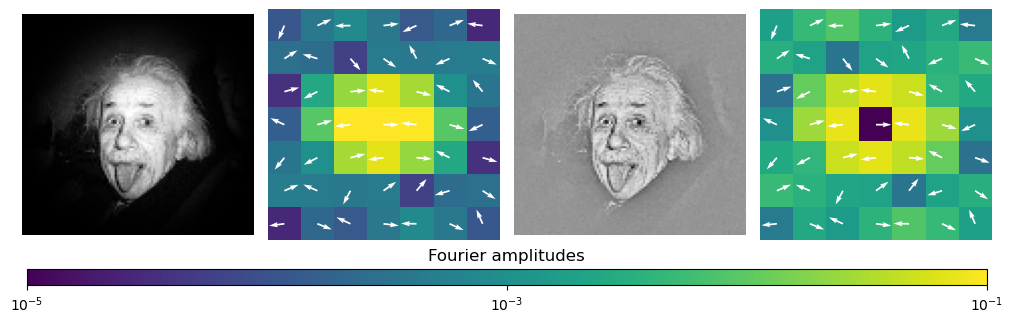

In [94]:
cmap = "viridis"
s2 = 8
xfft = fft_2d_center(x)#[::s2, ::s2])
yfft = fft_2d_center(y)#[::s2, ::s2])

xfft_n = xfft / jnp.abs(xfft)
yfft_n = yfft / jnp.abs(yfft)


Kmid1 = L1//2
Kmid2 = L2//2
L = 3
xfft_n = xfft_n[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1]
yfft_n = yfft_n[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1]

xfft_s = xfft[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1] 
yfft_s = yfft[Kmid1-L:Kmid1+L+1, Kmid2-L:Kmid2+L+1]

xfft_s = xfft_s / jnp.linalg.norm(xfft_s)
yfft_s = yfft_s / jnp.linalg.norm(yfft_s)
print(xfft.shape, yfft.shape)


#cmap = "twilight"
plt.figure(figsize=(10, 8))

plt.subplot(141)
plt.axis("off")
#plt.title("Template")
plt.imshow(x, cmap="Greys_r")

plt.subplot(142)
plt.axis("off")
#plt.title("Fourier phases")
l = 2

cmin = -5
cmax = -1
ticks = [5, 3, 1]
plt.imshow(jnp.log(jnp.abs(xfft_s)), cmap=cmap, vmin=cmin, vmax=cmax)
#plt.imshow(jnp.angle(xfft_n)%(l*jnp.pi), cmap=cmap, vmin=0, vmax=l*jnp.pi)
#plt.imshow(jnp.angle(xfft_n), cmap=cmap, vmin=-jnp.pi, vmax=jnp.pi)
plt.quiver(*jnp.meshgrid(jnp.arange(xfft_n.shape[0]), jnp.arange(xfft_n.shape[1])), xfft_n.real, xfft_n.imag, color="white", scale=15)




plt.subplot(143)
plt.axis("off")
#plt.title("Aligned Samples")
plt.imshow(y, cmap="Greys_r")


plt.subplot(144)
plt.axis("off")
#plt.title("Fourier phases")
#plt.imshow(jnp.log(jnp.abs(yfft)), cmap="Greys_r")
cax = plt.imshow(jnp.log(jnp.abs(yfft_s)), cmap=cmap, vmin=cmin, vmax=cmax)#, vmin=-jnp.pi, vmax=jnp.pi)
#plt.imshow(jnp.angle(yfft_n)%(l*jnp.pi), cmap=cmap, vmin=0, vmax=l*jnp.pi)
#cax = plt.imshow(jnp.angle(yfft_n), cmap=cmap, vmin=-jnp.pi, vmax=jnp.pi)
#plt.quiver(*jnp.meshgrid(jnp.arange(L1), jnp.arange(L2)), yfft_n.real, yfft_n.imag, color="white", scale=30)
plt.quiver(*jnp.meshgrid(jnp.arange(xfft_n.shape[0]), jnp.arange(xfft_n.shape[1])), yfft_n.real, yfft_n.imag, color="white", scale=15)

fig = plt.gcf()
fig.subplots_adjust(bottom=0.0)
cbar_ax = fig.add_axes([0.02, 0.3, 0.96, 0.02])
cbar = fig.colorbar(cax, ticks=[-r for r in ticks], cax=cbar_ax, orientation='horizontal')
cbar.ax.set_xticklabels(['$10^{-' + f'{r}' + '}$' for r in ticks])  # horizontal colorbar
cbar_ax.set_title("Fourier amplitudes")

plt.tight_layout()

fig.savefig("/home/emastr/github/multireference-alignment/figures/alignment.pdf", bbox_inches="tight")

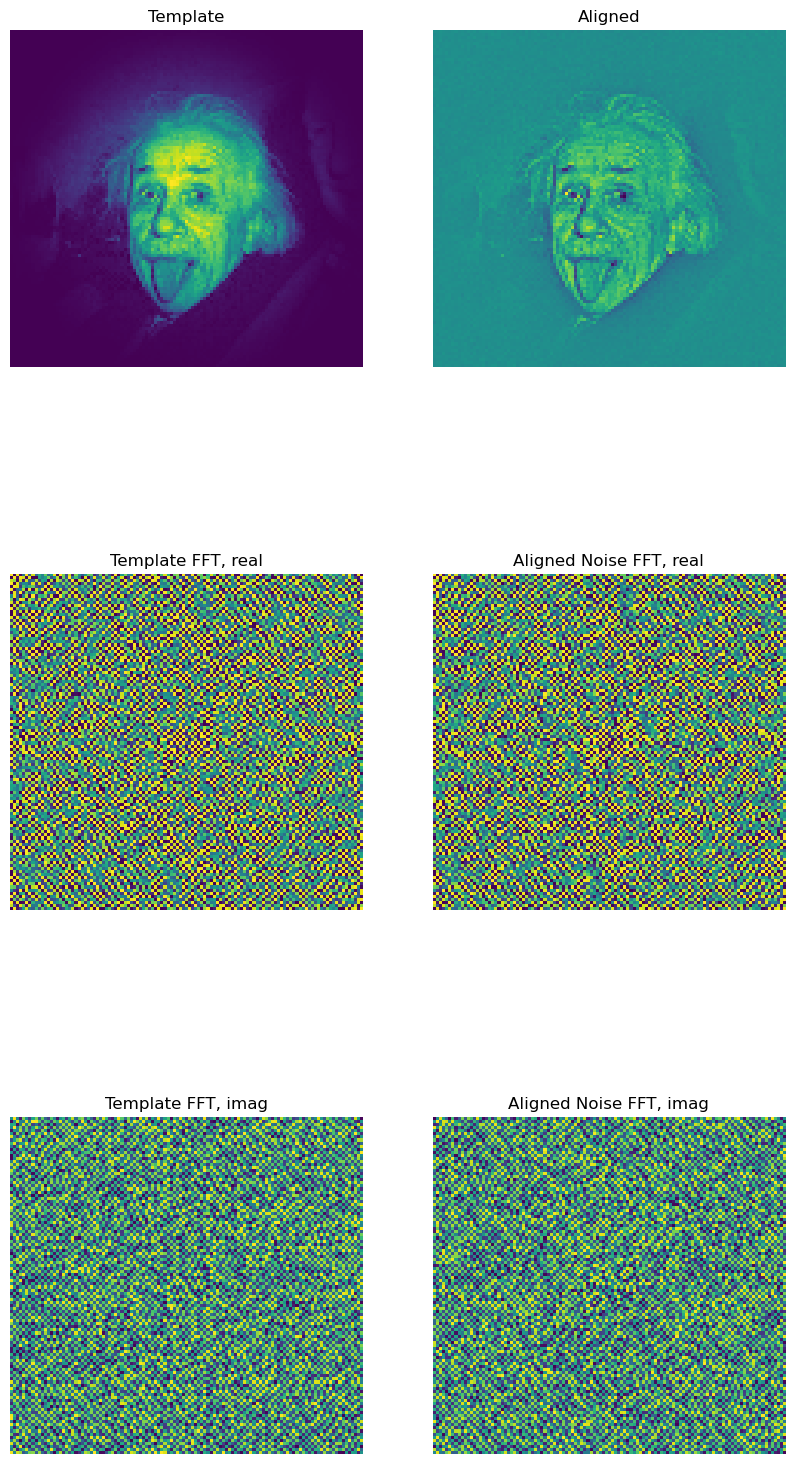

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(321)
plt.axis("off")
plt.title("Template")
plt.imshow(x)


xfft = fft_2d(x)/jnp.abs(fft_2d(x))
yfft = fft_2d(y)/jnp.abs(fft_2d(y))

plt.subplot(322)
plt.axis("off")
plt.title("Aligned")
plt.imshow(y)

plt.subplot(323)
plt.axis("off")
plt.title("Template FFT, real")
#plt.imshow(jnp.angle(fft_2d(x)))
plt.imshow(xfft.real)#, vmin=-1, vmax=1)

plt.subplot(324)
plt.axis("off")
plt.title("Aligned Noise FFT, real")
#plt.imshow(jnp.angle(fft_2d(y)))
plt.imshow(yfft.real)#, vmin=-1, vmax=1)


plt.subplot(325)
plt.axis("off")
plt.title("Template FFT, imag")
#plt.imshow(jnp.angle(fft_2d(x)))
plt.imshow(jnp.angle(xfft)*(jnp.pi*2))#, vmin=-1, vmax=1)

plt.subplot(326)
plt.axis("off")
plt.title("Aligned Noise FFT, imag")
#plt.imshow(jnp.angle(fft_2d(y)))
plt.imshow(jnp.angle(yfft)%(jnp.pi*2))#, vmin=-1, vmax=1)